<a href="https://colab.research.google.com/github/vnayakde/lane_detection/blob/main/lane_detection_model_enet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

binayakdey_rode_lane_estimation_path = kagglehub.dataset_download('binayakdey/rode-lane-estimation')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class LaneSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (512, 256), interpolation=cv2.INTER_NEAREST)


        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))


        mask = (mask > 127).astype(np.uint8)


        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)


In [ ]:
import torch
import torch.nn as nn

class InitialBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=16):
        super(InitialBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels - 3, kernel_size=3, stride=2, padding=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        conv_out = self.conv(x)
        pool_out = self.pool(x)
        out = torch.cat([conv_out, pool_out], dim=1)
        out = self.bn(out)
        return self.prelu(out)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, dilation=1,
                 downsample=False, asymmetric=False, dropout_prob=0.1):
        super(Bottleneck, self).__init__()
        internal_channels = out_channels // 4
        self.downsample = downsample


        self.conv1 = nn.Conv2d(in_channels, internal_channels, kernel_size=1,
                               stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(internal_channels)
        self.prelu1 = nn.PReLU()

        if asymmetric:
            self.conv2 = nn.Sequential(
                nn.Conv2d(internal_channels, internal_channels, (1, kernel_size),
                          stride=2 if downsample else 1,
                          padding=(0, padding), bias=False),
                nn.Conv2d(internal_channels, internal_channels, (kernel_size, 1),
                          padding=(padding, 0), bias=False)
            )
        else:
            self.conv2 = nn.Conv2d(internal_channels, internal_channels, kernel_size=kernel_size,
                                   stride=2 if downsample else 1,
                                   padding=padding, dilation=dilation, bias=False)

        self.bn2 = nn.BatchNorm2d(internal_channels)
        self.prelu2 = nn.PReLU()

        self.conv3 = nn.Conv2d(internal_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout_prob)


        if downsample or in_channels != out_channels:
            self.skip_proj = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=2 if downsample else 1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip_proj = None

        self.prelu_out = nn.PReLU()

    def forward(self, x):
        identity = x

        out = self.prelu1(self.bn1(self.conv1(x)))
        out = self.prelu2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.dropout(out)

        if self.skip_proj is not None:
            identity = self.skip_proj(identity)


        if out.shape[-2:] != identity.shape[-2:]:
            diffH = identity.shape[-2] - out.shape[-2]
            diffW = identity.shape[-1] - out.shape[-1]
            out = F.pad(out, [0, diffW, 0, diffH])

        out += identity
        return self.prelu_out(out)



In [ ]:
import torch
import torch.nn as nn

class ENetEncoder(nn.Module):
    def __init__(self):
        super(ENetEncoder, self).__init__()

        self.initial = InitialBlock()

        # Stage 1
        self.bottleneck1_0 = Bottleneck(16, 64, downsample=True)
        self.bottleneck1_1 = Bottleneck(64, 64)
        self.bottleneck1_2 = Bottleneck(64, 64)
        self.bottleneck1_3 = Bottleneck(64, 64)
        self.bottleneck1_4 = Bottleneck(64, 64)

        # Stage 2
        self.bottleneck2_0 = Bottleneck(64, 128, downsample=True)  # Downsample
        self.bottleneck2_1 = Bottleneck(128, 128)
        self.bottleneck2_2 = Bottleneck(128, 128, dilation=2)
        self.bottleneck2_3 = Bottleneck(128, 128, asymmetric=True)
        self.bottleneck2_4 = Bottleneck(128, 128, dilation=4)
        self.bottleneck2_5 = Bottleneck(128, 128)
        self.bottleneck2_6 = Bottleneck(128, 128, dilation=8)
        self.bottleneck2_7 = Bottleneck(128, 128, asymmetric=True)
        self.bottleneck2_8 = Bottleneck(128, 128, dilation=16)

    def forward(self, x):
        x = self.initial(x)

        # Stage 1
        x = self.bottleneck1_0(x)
        x = self.bottleneck1_1(x)
        x = self.bottleneck1_2(x)
        x = self.bottleneck1_3(x)
        x = self.bottleneck1_4(x)

        # Stage 2
        x = self.bottleneck2_0(x)
        x = self.bottleneck2_1(x)
        x = self.bottleneck2_2(x)
        x = self.bottleneck2_3(x)
        x = self.bottleneck2_4(x)
        x = self.bottleneck2_5(x)
        x = self.bottleneck2_6(x)
        x = self.bottleneck2_7(x)
        x = self.bottleneck2_8(x)

        return x


In [ ]:
import torch.nn as nn

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, stride=2,
            padding=1, output_padding=1, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class ENetDecoder(nn.Module):
    def __init__(self, num_classes):
        super(ENetDecoder, self).__init__()
        self.decoder1 = DecoderBlock(128, 64)
        self.decoder2 = DecoderBlock(64, 16)
        self.final = nn.ConvTranspose2d(16, num_classes, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.final(x)
        return x


In [ ]:
import torch.nn as nn

class ENet(nn.Module):
    def __init__(self, num_classes):
        super(ENet, self).__init__()
        self.encoder = ENetEncoder()
        self.decoder = ENetDecoder(num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_image_dir = "/kaggle/input/rode-lane-estimation/rode_lane_estimation/train/images"
train_mask_dir = "/kaggle/input/rode-lane-estimation/rode_lane_estimation/train/labels"
val_image_dir = "/kaggle/input/rode-lane-estimation/rode_lane_estimation/valid/images"
val_mask_dir = "/kaggle/input/rode-lane-estimation/rode_lane_estimation/valid/labels"


num_classes = 2
lr = 1e-3
batch_size = 4
epochs = 25

train_dataset = LaneSegmentationDataset(train_image_dir, train_mask_dir)
val_dataset = LaneSegmentationDataset(val_image_dir, val_mask_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)


model = ENet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Train Loss: {total_loss / len(train_loader):.4f}")


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "enet_best.pth")
        print("Saved new best model.")

Epoch 1/25: 100%|██████████| 93/93 [00:09<00:00,  9.42it/s]


Train Loss: 0.3873
Val Loss: 0.2562
Saved new best model.


Epoch 2/25: 100%|██████████| 93/93 [00:06<00:00, 14.35it/s]


Train Loss: 0.2272
Val Loss: 0.1974
Saved new best model.


Epoch 3/25: 100%|██████████| 93/93 [00:06<00:00, 14.35it/s]


Train Loss: 0.1914
Val Loss: 0.1797
Saved new best model.


Epoch 4/25: 100%|██████████| 93/93 [00:06<00:00, 14.05it/s]


Train Loss: 0.1738
Val Loss: 0.1362
Saved new best model.


Epoch 5/25: 100%|██████████| 93/93 [00:06<00:00, 14.66it/s]


Train Loss: 0.1635
Val Loss: 0.1145
Saved new best model.


Epoch 6/25: 100%|██████████| 93/93 [00:06<00:00, 14.08it/s]


Train Loss: 0.1544
Val Loss: 0.1273


Epoch 7/25: 100%|██████████| 93/93 [00:06<00:00, 13.94it/s]


Train Loss: 0.1504
Val Loss: 0.2326


Epoch 8/25: 100%|██████████| 93/93 [00:06<00:00, 13.87it/s]


Train Loss: 0.1410
Val Loss: 0.1121
Saved new best model.


Epoch 9/25: 100%|██████████| 93/93 [00:06<00:00, 14.72it/s]


Train Loss: 0.1449
Val Loss: 0.1316


Epoch 10/25: 100%|██████████| 93/93 [00:06<00:00, 14.83it/s]


Train Loss: 0.1451
Val Loss: 0.1028
Saved new best model.


Epoch 11/25: 100%|██████████| 93/93 [00:06<00:00, 14.05it/s]


Train Loss: 0.1288
Val Loss: 0.1233


Epoch 12/25: 100%|██████████| 93/93 [00:06<00:00, 14.77it/s]


Train Loss: 0.1226
Val Loss: 0.0897
Saved new best model.


Epoch 13/25: 100%|██████████| 93/93 [00:06<00:00, 14.78it/s]


Train Loss: 0.1208
Val Loss: 0.1186


Epoch 14/25: 100%|██████████| 93/93 [00:06<00:00, 14.63it/s]


Train Loss: 0.1181
Val Loss: 0.0966


Epoch 15/25: 100%|██████████| 93/93 [00:06<00:00, 14.39it/s]


Train Loss: 0.1109
Val Loss: 0.1264


Epoch 16/25: 100%|██████████| 93/93 [00:06<00:00, 14.93it/s]


Train Loss: 0.1083
Val Loss: 0.1263


Epoch 17/25: 100%|██████████| 93/93 [00:06<00:00, 14.90it/s]


Train Loss: 0.1090
Val Loss: 0.1064


Epoch 18/25: 100%|██████████| 93/93 [00:06<00:00, 14.80it/s]


Train Loss: 0.1067
Val Loss: 0.1445


Epoch 19/25: 100%|██████████| 93/93 [00:06<00:00, 13.96it/s]


Train Loss: 0.1061
Val Loss: 0.1131


Epoch 20/25: 100%|██████████| 93/93 [00:06<00:00, 14.68it/s]


Train Loss: 0.0982
Val Loss: 0.1046


Epoch 21/25: 100%|██████████| 93/93 [00:06<00:00, 14.58it/s]


Train Loss: 0.0974
Val Loss: 0.1231


Epoch 22/25: 100%|██████████| 93/93 [00:06<00:00, 14.72it/s]


Train Loss: 0.0929
Val Loss: 0.1204


Epoch 23/25: 100%|██████████| 93/93 [00:06<00:00, 14.66it/s]


Train Loss: 0.0909
Val Loss: 0.1468


Epoch 24/25: 100%|██████████| 93/93 [00:06<00:00, 14.78it/s]


Train Loss: 0.0850
Val Loss: 0.1197


Epoch 25/25: 100%|██████████| 93/93 [00:06<00:00, 14.11it/s]


Train Loss: 0.0884
Val Loss: 0.1121


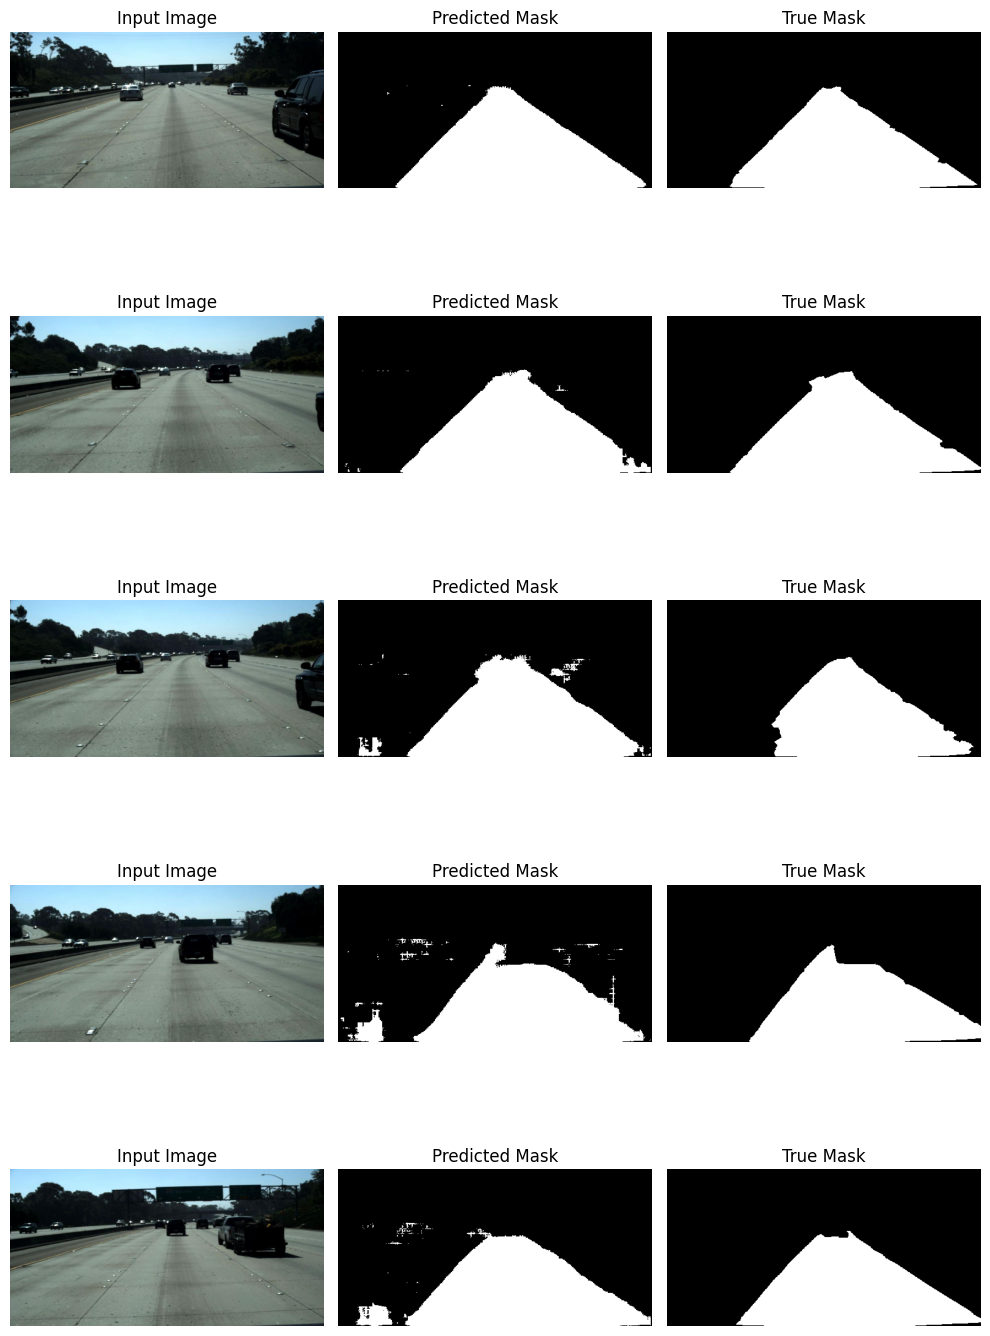

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = ENet(num_classes).to(device)
model.load_state_dict(torch.load("enet_best.pth", map_location=device))
model.eval()

test_image_dir = "/kaggle/input/rode-lane-estimation/rode_lane_estimation/test/images"
test_mask_dir = "/kaggle/input/rode-lane-estimation/rode_lane_estimation/test/labels"

test_dataset = LaneSegmentationDataset(test_image_dir, test_mask_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


def show_results_table(test_loader, num_samples=15):
    """
    Displays predictions and ground truth in a table for `num_samples` samples.
    """
    plt.figure(figsize=(10, num_samples * 3))
    shown = 0
    for images, masks in test_loader:
        if shown >= num_samples:
            break
        images = images.to(device)
        with torch.no_grad():
            logits = model(images)
            preds = torch.argmax(logits, dim=1).cpu().numpy()[0]
            true_mask = masks.cpu().numpy()[0]

        image_np = images.cpu().numpy()[0]
        image_np = np.transpose(image_np, (1, 2, 0))


        plt.subplot(num_samples, 3, shown * 3 + 1)
        plt.imshow(image_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, shown * 3 + 2)
        plt.imshow(preds, cmap="gray", vmin=0, vmax=1)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, shown * 3 + 3)
        plt.imshow(true_mask, cmap="gray", vmin=0, vmax=1)
        plt.title("True Mask")
        plt.axis("off")
        shown += 1

    plt.tight_layout()
    plt.show()

show_results_table(test_loader, num_samples=5)
